# Flowers recognition
### Basic ML models for https://www.kaggle.com/alxmamaev/flowers-recognition.
#### Wojciech Fica, Adam Kuczaj.

**Notes**:
- warto przeczytać: https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4.
- Adaś, używjaj GPU (instrukcja poniżej). Wpp funkcja `get_features()` bardo wolno działa.
- Mamy sporo danych --> jest czasem problem z garbage collectorem i program się wysypuje bo RAM jest pełen. Można pisać kod w funkcjach to gc wtedy ładnie i na bierząco usuwa tymczasowe rzeczy z pamięci. 

## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# The main part

In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.models import Model
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split

#### Read the data set.

In [3]:
!git clone https://github.com/wfica/flowers-recognition.git

fatal: destination path 'flowers-recognition' already exists and is not an empty directory.


In [4]:
def read_dataset(data_path = 'flowers-recognition/data', random_state=42):
  """
  Reads datasets and splits it into train and test subsets. Fix random_state for
  reproducible results.

  Returns: a tuple (x_train, x_test, y_train, y_test).
  """
  xs = []
  ys = []

  for label in os.listdir(data_path):
    for img_path in os.listdir(data_path + '/' + label):
      img = image.load_img(data_path + '/' + label + '/' + img_path, target_size=(224, 224))
      x = image.img_to_array(img)
      x = preprocess_input(x)
      xs.append(x)
      ys.append(label)

  x = np.array(xs)
  y = np.array(ys)

  return train_test_split(x, y, test_size=0.33, random_state=random_state)

In [5]:
x_train, x_test, y_train, y_test = read_dataset()
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(2892, 224, 224, 3) (2892,)
(1425, 224, 224, 3) (1425,)


In [6]:
def check_uniform_data_split():
  """ 
  Makes sure that the train dataset has ~2x more samples for each label than the test dataset.
  """
  train_labels_cnts = pd.DataFrame(y_train).value_counts()
  test_labels_cnts = pd.DataFrame(y_test).value_counts()
  train_test_ratio_df = train_labels_cnts / test_labels_cnts
  assert train_test_ratio_df.min() > 1.8
  assert train_test_ratio_df.max() < 2.2

check_uniform_data_split()

#### Prepare the VGG16 NN.

We use `include_top=False` to remove the classification layer that was trained on the ImageNet dataset and set the model as not `trainable`.

In [7]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3) )
vgg_model.trainable = False

vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Get features & encode labels

In [8]:
def get_features(xs):
  """ Given train or test data outputs features produced by the VGG16 model."""
  features_extractor = vgg_model.predict(xs)
  return features_extractor.reshape(features_extractor.shape[0], -1)

In [9]:
train_features = get_features(x_train)
print(train_features.shape)
test_features = get_features(x_test)
print(test_features.shape)

(2892, 25088)
(1425, 25088)


In [45]:
le = preprocessing.LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc =  le.fit_transform(y_test)

## Train various ML models

### RandomForest

From [[sklearn]](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html):
> A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

In [12]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(train_features, y_train_enc)

RandomForestClassifier(random_state=0)

In [61]:
rf_prediction = rf.predict(test_features)
rf_prediction_names = le.inverse_transform(rf_prediction)

In [18]:
print(f"Random forest accuracy: {metrics.accuracy_score(y_test_enc, rf_prediction).round(decimals=2)}")

Random forest accuracy: 0.81


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 2880x5760 with 0 Axes>

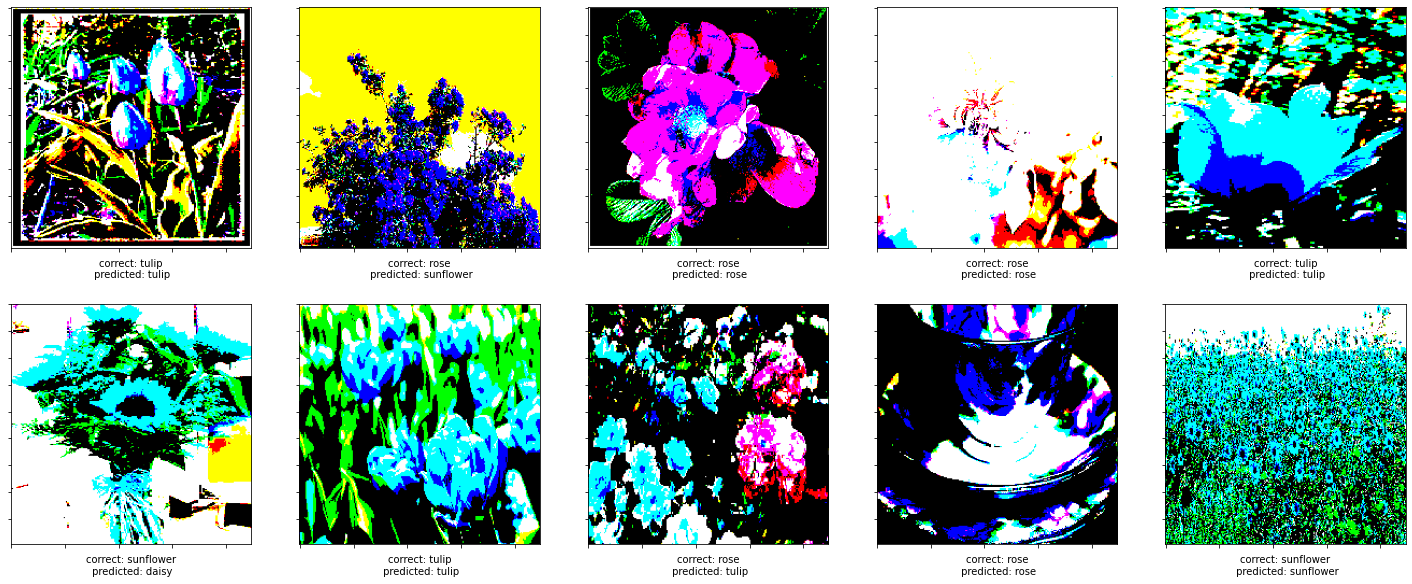

In [69]:
# from matplotlib.pyplot import figure
plt.figure(figsize=(40,80)) 

fig, axs = plt.subplots(2, 5, figsize=(25, 10))

for i, ax in enumerate(axs.flat):
  ax.imshow(x_test[i])
  ax.set(xlabel=f"correct: {y_test[i]}\n predicted: {rf_prediction_names[i]}")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])

### SVM

### Logistic Regression

### KNN